# Gaussian Naive Bayes From Scratch (Lab 5)
This notebook implements GNB from first principles and evaluates it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler


## Load Dataset (Iris)

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((105, 4), (45, 4))

## Gaussian Naive Bayes (From Scratch)

In [3]:
class GaussianNaiveBayes:
    def fit(self, X, y, eps=1e-6):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}
        self.eps = eps

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + eps   # handle zero variance
            self.prior[c] = len(X_c) / len(X)

    def gaussian(self, x, mean, var):
        num = np.exp(- (x - mean)**2 / (2 * var))
        den = np.sqrt(2 * np.pi * var)
        return num / den

    def predict_one(self, x):
        posteriors = []
        for c in self.classes:
            prior_log = np.log(self.prior[c])
            class_likelihood = np.sum(np.log(self.gaussian(x, self.mean[c], self.var[c])))
            posteriors.append(prior_log + class_likelihood)
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])


## Train & Evaluate

In [4]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)

acc, prec, rec, f1, cm

(0.9777777777777777,
 0.9761904761904763,
 0.9743589743589745,
 0.974320987654321,
 array([[19,  0,  0],
        [ 0, 12,  1],
        [ 0,  0, 13]]))

## ROC Curve (One-vs-Rest)

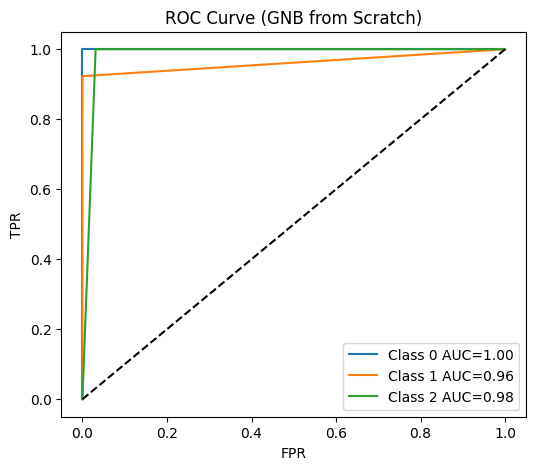

In [5]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,5))
for i in roc_auc:
    plt.plot(fpr[i], tpr[i], label=f"Class {i} AUC={roc_auc[i]:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve (GNB from Scratch)")
plt.legend()
plt.show()
